In [ ]:
import scipy
import numpy as np
import pandas as pd
import xarray as xr
import scicomap as sc
from pathlib import Path
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
import lib.size_distribution as size_distribution
from lib.radiative_forcing import SocratesExperiment, EasyAerosolExperiment
from lib.grid_utils import spatial_mean, spatial_integral
from lib.plot_utils import truncate_colormap, plot_contourf_map, plot_pcolormesh_map

In [3]:
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.default'] = 'default'
mpl.rcParams['font.size'] = '10'
mpl.rcParams['axes.titlesize'] = '10'
mpl.rcParams['axes.labelsize'] = '10'
mpl.rcParams['xtick.labelsize'] = '10'
mpl.rcParams['ytick.labelsize'] = '10'
mpl.rcParams['hatch.linewidth'] = 0.8

lwmult = 1
mpl.rcParams['axes.linewidth'] = lwmult * mpl.rcParamsDefault['axes.linewidth']
mpl.rcParams['lines.markersize'] = lwmult * mpl.rcParamsDefault['lines.markersize']
mpl.rcParams['xtick.major.size'] = lwmult * mpl.rcParamsDefault['xtick.major.size']
mpl.rcParams['xtick.major.width'] = lwmult * mpl.rcParamsDefault['xtick.major.width']
mpl.rcParams['ytick.major.size'] = lwmult * mpl.rcParamsDefault['ytick.major.size']
mpl.rcParams['ytick.major.width'] = lwmult * mpl.rcParamsDefault['ytick.major.width']

textheight = 8.67886
textwidth = 6.17838

# Figure 1: Summary of radiative forcings

These are the IRF and adjustment components of radiative forcings from Thornhill (2021), given in Table 3 (for IRFs) and Tables S5b--d of the supplementary information (for adjustments).

This is organised into an array with shape `(4,3,7)`:
- 4 models (UKESM1, CNRM-ESM2, NorESM2, MRI-ESM2);
- 3 aerosol species (sulfate, organic carbon, black carbon);
- 7 components (IRFari, albedo adjustment, cloud adjustment, water vapor adjustment, tropospheric temperature adjustment, stratospheric temperature adjustment, and surface temperature adjustment).

A handful of helper variables can assist with indexing into this array, e.g.
```python
thornhill_data[:, SPECIES['BC'], ERFari].sum(axis=1) # results in [0.325, 0.103, 0.358, 0.146] corresponding to the 4 models
```
will access (`ERFari` in the third index) and sum up (`.sum(axis=1)`) the components to calculate ERFari for black carbon (`SPECIES['BC']` in the second index) across all models (`:` in the first index).

In [4]:
thornhill_data = np.array([
    # columns are: IRFari, albedo, cloud, W.V., T_trop, T_strat, T_surface
    
    # UKESM1
    [[-0.49, -0.030, -0.790, -0.100, +0.200, -0.020, +0.040], # sulfate
     [-0.15, -0.015, +0.052, -0.018, +0.023, -0.003, +0.015], # OC
     [+0.37, -0.013, -0.013, +0.057, -0.137, +0.043, +0.005]], # BC
    
    # CNRM-ESM2
    [[-0.29, +0.010, -0.490, -0.040, +0.100, -0.010, +0.030], # sulfate
     [-0.07, +0.008, -0.083, +0.000, +0.025, -0.019, +0.011], # OC
     [+0.13, +0.003, -0.010, +0.060, -0.088, -0.003, +0.001]], # BC
    
    # NorESM2
    [[-0.19, -0.090, -0.960, -0.050, +0.160, -0.030, +0.010], # sulfate
     [-0.07, +0.002, -0.100, -0.008, +0.066, -0.016, +0.010], # OC
     [+0.35, +0.076, -0.067, +0.097, -0.137, -0.025, -0.003]], # BC
    
    # MRI-ESM2
    [[-0.48, -0.040, -0.730, -0.050, +0.080, -0.020, +0.060], # sulfate
     [-0.07, -0.006, -0.129, -0.009, -0.016, -0.010, +0.009], # OC
     [+0.26, +0.067, +0.163, +0.329, -0.509, +0.021, -0.022]], # BC
])

MODEL = {'UKESM1': 0, 'CNRM-ESM2': 1, 'NorESM2': 2, 'MRI-ESM2': 3}
SPECIES = {'sulfate': 0, 'OC': 1, 'BC': 2}

# sets of column indices for getting different radiative forcings
adjustments = [1,2,3,4,5,6]
IRFari = 0
ERFari = [0,1,3,4,5,6]
ERF = [0,1,2,3,4,5,6]

Here I calculate ERF$_\text{ari}$ as IRF$_\text{ari}$ + all of the non-cloud adjustments, with the uncertainty as half the spread across models:

In [5]:
uncertainty = lambda d: (d.max() - d.min()) / 2

print('Forcing agent   IRFari             ERFari')
for species, idx in SPECIES.items():
    irf_mean = thornhill_data[:, idx, IRFari].mean()
    irf_err = uncertainty(thornhill_data[:, idx, IRFari])

    erf_mean = thornhill_data[:, idx, ERFari].sum(axis=1).mean()
    erf_err = uncertainty(thornhill_data[:, idx, ERFari].sum(axis=1))
    
    print(species.ljust(15), f'{irf_mean:+.4f} ± {irf_err:.4f}'.ljust(18), f'{erf_mean:+.4f} ± {erf_err:.4f}')

Forcing agent   IRFari             ERFari
sulfate         -0.3625 ± 0.1500   -0.3100 ± 0.1300
OC              -0.0900 ± 0.0400   -0.0777 ± 0.0660
BC              +0.2775 ± 0.1200   +0.2330 ± 0.1275


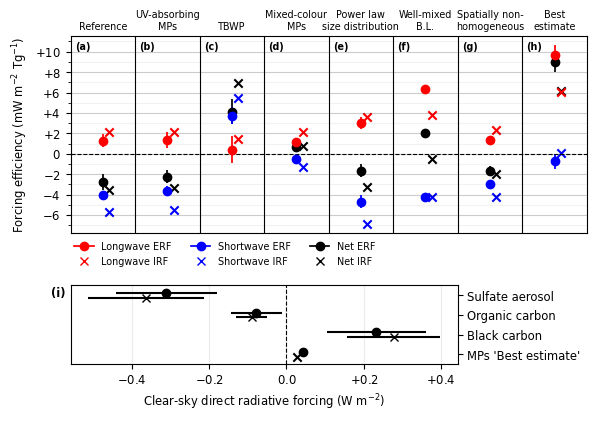

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(textwidth, (1/2+1/5)*textwidth), height_ratios=[1/2, 1/5])

#================================================================================

linewidth = 1.25

for i, expt_str in enumerate(names := [
    'clear_gamma(1-100)_exponential(0.3,2km)_uniform(1680m-3)',
    'clearUV_gamma(1-100)_exponential(0.3,2km)_uniform(1760m-3)',
    'black_gamma(1-100)_exponential(0.3,2km)_uniform(860m-3)',
    'mixedUV_gamma(1-100)_exponential(0.3,2km)_uniform(7230m-3)',
    'clear_powerlaw(1.52,1-100)_exponential(0.3,2km)_uniform(5710m-3)',
    'clear_gamma(1-100)_wellmixedBL_uniform(2620m-3)',
    'clear_gamma(1-100)_exponential(0.3,2km)_evangeliou(3070m-3)',
    'mixedUV_powerlaw(1.52,1-100)_wellmixedBL_evangeliou(650m-3)',
]):
    ea_expt = EasyAerosolExperiment(expt_str)
    soc_expt = SocratesExperiment(expt_str)

    ea_expt_scaling = 1e3 / (ea_expt.total_plastic_burden / 1e9) # convert W/m2 to mW/m2/Tg
    soc_expt_scaling = 1e3 / (soc_expt.total_plastic_burden / 1e9)

    low, mean, high = ea_expt.net_forcing_95ci() * ea_expt_scaling
    irf = soc_expt.global_mean_net_forcing() * soc_expt_scaling
    ax1.errorbar(i, mean, yerr=[[abs(low-mean)], [high-mean]], marker='o', c='k', linewidth=linewidth)
    ax1.scatter(i+.1, irf, marker='x', c='k')

    low, mean, high = ea_expt.longwave_forcing_95ci() * ea_expt_scaling
    irf = soc_expt.global_mean_longwave_forcing() * soc_expt_scaling
    ax1.errorbar(i, mean, yerr=[[abs(low-mean)], [high-mean]], marker='o', c='r', linewidth=linewidth)
    ax1.scatter(i+.1, irf, marker='x', c='r')
    
    low, mean, high = ea_expt.shortwave_forcing_95ci() * ea_expt_scaling
    irf = soc_expt.global_mean_shortwave_forcing() * soc_expt_scaling
    ax1.errorbar(i, mean, yerr=[[abs(low-mean)], [high-mean]], marker='o', c='b', linewidth=linewidth)
    ax1.scatter(i+.1, irf, marker='x', c='b')

    ax1.annotate(f'({chr(97+i)})', xy=(i/len(names)+.008, .97), xycoords='axes fraction',
                    xytext=(0,0), textcoords='offset fontsize',
                    fontsize='x-small', fontweight='bold', ha='left', va='top')

ax1.axhline(0, lw=.8, c='k', ls='--')
for i in range(len(names)-1):
    ax1.axvline(i+.5, lw=.8, c='k')

ax1.set_xlim(left=-.5, right=len(names)-.5)
ax1.set_xticks(range(len(names)), [
    'Reference', 'UV-absorbing\nMPs', 'TBWP', 'Mixed-colour\nMPs',
    'Power law\nsize distribution', 'Well-mixed\nB.L.', 'Spatially non-\nhomogeneous', 'Best\nestimate'])
ax1.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, length=0, labelsize='x-small')

ax1.set_ylabel(r'Forcing efficiency (mW m$^{-2}$ Tg$^{-1}$)', fontsize='small')

ax1.tick_params(axis='y', labelsize='small')
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax1.yaxis.set_major_formatter(lambda x, _: rf'${x:+.0f}$' if x != 0 else rf'${x:.0f}$')
ax1.grid(axis='y', lw=.8, alpha=.2, c='k')
ax1.grid(axis='y', which='minor', lw=.8, alpha=.05, c='k')

legend_elements = [mpl.lines.Line2D([0], [0], color='r', marker='o', linewidth=linewidth, label='Longwave ERF'),
                   mpl.lines.Line2D([0], [0], color='r', marker='x', linewidth=0, label='Longwave IRF'),
                   mpl.lines.Line2D([0], [0], color='b', marker='o', linewidth=linewidth, label='Shortwave ERF'),
                   mpl.lines.Line2D([0], [0], color='b', marker='x', linewidth=0, label='Shortwave IRF'),
                   mpl.lines.Line2D([0], [0], color='k', marker='o', linewidth=linewidth, label='Net ERF'),
                   mpl.lines.Line2D([0], [0], color='k', marker='x', linewidth=0, label='Net IRF'),]
ax1.legend(handles=legend_elements, frameon=False, fontsize='x-small', ncols=3,
          bbox_to_anchor=(0, -.025), loc='upper left', borderaxespad=0.)

#================================================================================

plt.tight_layout()
ax1_width = ax1.get_position().width

uncertainty = lambda d: (d.max() - d.min()) / 2

for i, species in enumerate(['sulfate', 'OC', 'BC']):
    values = thornhill_data[:, SPECIES[species], IRFari]
    ax2.errorbar([values.mean()], [4-(i+1)-.12], xerr=[uncertainty(values)], c='k', marker='x')
    
    values = thornhill_data[:, SPECIES[species], ERFari].sum(axis=1)
    ax2.errorbar([values.mean()], [4-(i+1)+.12], xerr=[uncertainty(values)], fmt='o', color='k')

ax2.scatter([28.618e-3], [-.12], c='k', marker='x', zorder=100) # MP best estimate IRF
ax2.errorbar([42.010e-3], [.12], xerr=[4.618e-3], fmt='o', color='k') # MP best estimate ERF

ax2.set_yticks(range(4), ["MPs 'Best estimate'", 'Black carbon', 'Organic carbon', 'Sulfate aerosol'])
ax2.tick_params(labelsize='small')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(-0.5, 3.5)

ax2.axvline(0, c='k', lw=.8, ls='--')
ax2.grid(axis='x', alpha=.25)

ax2.set_xlabel('Clear-sky direct radiative forcing (W m$^{-2}$)', fontsize='small')
ax2.xaxis.set_major_formatter(lambda x, _: rf'${x:+.1f}$' if x != 0 else rf'${x:.1f}$')

ax2.annotate(f'(i)', xy=(-0.05, .99), xycoords='axes fraction',
             xytext=(0,0), textcoords='offset fontsize',
             fontsize='small', fontweight='bold', ha='left', va='top')

#================================================================================

plt.tight_layout()

pos = ax2.get_position()
ax2.set_position([pos.x0, pos.y0, ax1_width * .75, pos.height])

pos = ax1.get_position()
ax1.set_position([pos.x0, pos.y0, ax1_width, pos.height])

fig.savefig('figures/fig1.pdf', bbox_inches='tight');

# Figure 2: Size distribution of MP particles

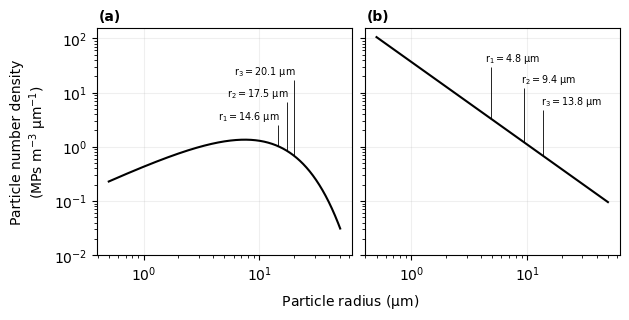

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(textwidth, textwidth/2), sharex=True, sharey=True, layout='constrained')

#================================================================================

gamma = size_distribution.Revell2021GammaSizeDistribution(r_min=1/2, r_max=100/2)
powerlaw = size_distribution.Leusch2023PowerLawSizeDistribution(r_min=1/2, r_max=100/2)

lower_diameter, upper_diameter = 50, 100 # bin boundaries for Leusch et al. estimate
leusch_50_100_concentration = scipy.integrate.quad(lambda d: 10**(1.72 - 1.52*np.log10(d)), lower_diameter, upper_diameter)[0]

gamma_correction_factor = leusch_50_100_concentration / gamma.nth_moment(0, r_min=lower_diameter/2, r_max=upper_diameter/2)
powerlaw_correction_factor = leusch_50_100_concentration / powerlaw.nth_moment(0, r_min=lower_diameter/2, r_max=upper_diameter/2)

#================================================================================

radius = np.linspace(gamma.r_min, gamma.r_max, 10_000)
ax1.plot(radius, gamma_correction_factor * gamma.pdf(radius), 'k-')
ax2.plot(radius, powerlaw_correction_factor * powerlaw.pdf(radius), 'k-')

for moment, strike_length in zip([1,2,3], [.4, .9, 1.4]):
    r = gamma.nth_moment(moment)**(1/moment)
    y = gamma_correction_factor * gamma.pdf(r)
    
    ax1.vlines(r, y, y * 10**strike_length, color='k', lw=.6)
    ax1.text(r+.5, y * 10**(strike_length+.03), rf'$r_{moment}={r:.1f}$ μm',
             ha='right', va='bottom', fontsize='x-small')

for moment, strike_length in zip([1,2,3], [.95, 1, .85]):
    r = powerlaw.nth_moment(moment)**(1/moment)
    y = powerlaw_correction_factor * powerlaw.pdf(r)
    
    ax2.vlines(r, y, y * 10**strike_length, color='k', lw=.6)
    ax2.text(r-.5, y * 10**(strike_length+.03), rf'$r_{moment}={r:.1f}$ μm',
             ha='left', va='bottom', fontsize='x-small')

ax1.loglog()
ax1.set_ylim(bottom=1e-2)

fig.supxlabel(r'                Particle radius ($\mu$m)', fontsize='medium')
ax1.set_ylabel('Particle number density\n'+r'(MPs m$^{-3}$ $\mu$m$^{-1}$)')

for ax in [ax1, ax2]:
    ax.grid(lw=.8, alpha=.2)

ax1.annotate(f'(a)', xy=(-0.02, 1.11), xycoords='axes fraction', xytext=(+0.5, -0.5), textcoords='offset fontsize',
             fontsize='medium', fontweight='bold', ha='left', va='top')

ax2.annotate(f'(b)', xy=(-0.02, 1.11), xycoords='axes fraction', xytext=(+0.5, -0.5), textcoords='offset fontsize',
             fontsize='medium', fontweight='bold', ha='left', va='top')

#================================================================================

fig.savefig('figures/fig2.pdf', bbox_inches='tight')

# Figure 3: MP optical properties

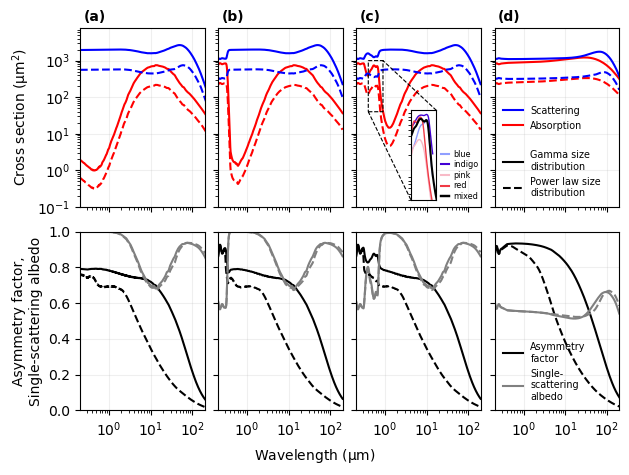

In [8]:
fig, axs = plt.subplots(2,4, figsize=(textwidth, textwidth*3/4), layout='constrained', sharex=True, sharey='row')

#================================================================================

# we use .rolling to slightly smooth the line, which improves readability especially for the dashed line
wavelength = lambda src: src['wavelength [μm]'].rolling(3).mean()
absorption = lambda src: src['Cabs [μm^2]'].rolling(3).mean()
scattering = lambda src: src['Csca [μm^2]'].rolling(3).mean()
asymmetry = lambda src: src['g [1]'].rolling(3).mean()
single_scattering_albedo = lambda src: scattering(src) / (scattering(src) + absorption(src))

for col, colour in enumerate(['clear', 'clearUV', 'mixedUV', 'black']):
    gamma = pd.read_csv(f'data/spectra/{colour}_gamma(1-100).csv')
    powerlaw = pd.read_csv(f'data/spectra/{colour}_powerlaw(1.52,1-100).csv')

    x = wavelength(gamma)
    axs[0,col].plot(x, absorption(gamma), 'r-')
    axs[0,col].plot(x, scattering(gamma), 'b-')
    axs[1,col].plot(x, asymmetry(gamma), c='k', ls='-')
    axs[1,col].plot(x, single_scattering_albedo(gamma), c='grey', ls='-')

    x = wavelength(powerlaw)
    axs[0,col].plot(x, absorption(powerlaw), 'r--')
    axs[0,col].plot(x, scattering(powerlaw), 'b--')
    axs[1,col].plot(x, asymmetry(powerlaw), c='k', ls='--')
    axs[1,col].plot(x, single_scattering_albedo(powerlaw), c='grey', ls='--')

    axs[1,col].set_ylim(0,1)

    axs[0,col].annotate(f'({chr(97+col)})', xy=(-0.03, 1.14), xycoords='axes fraction',
                        xytext=(+0.5, -0.5), textcoords='offset fontsize',
                        fontsize='medium', fontweight='bold', ha='left', va='top')

axs[0,0].set_xscale('log')
axs[0,0].set_xlim(x.min(), x.max())
axs[0,0].set_yscale('log')
axs[0,0].set_ylim(bottom=1e-1)

legend_lines = [mpl.lines.Line2D([0], [0], color='b'),
                mpl.lines.Line2D([0], [0], color='r'),
                mpl.lines.Line2D([0], [0], alpha=0),
                mpl.lines.Line2D([0], [0], color='k', ls='-'),
                mpl.lines.Line2D([0], [0], color='k', ls='--'),]
axs[0,3].legend(legend_lines, ['Scattering', 'Absorption', '',
                               'Gamma size\ndistribution', 'Power law size\ndistribution'],
                frameon=False, fontsize='x-small')

legend_lines = [mpl.lines.Line2D([0], [0], color='k'),
                mpl.lines.Line2D([0], [0], color='grey'),]
axs[1,3].legend(legend_lines, ['Asymmetry\nfactor', 'Single-\nscattering\nalbedo'],
                frameon=False, fontsize='x-small')

#================================================================================

axins = axs[0,2].inset_axes((.44, .04, .206, .499), transform=axs[0,2].transAxes,
                            xscale='log', xlim=(.40, .9), yscale='log', ylim=(40, 1000))
axins.set_yticks([])
axins.set_xticks([], minor=True)

connectors = axs[0,2].indicate_inset_zoom(axins, edgecolor="k", ls='--', alpha=1, lw=.8).connectors
connectors[0].set(visible=True, lw=.8, ls='--')
connectors[3].set(visible=True, lw=.8, ls='--')
connectors[1].set(visible=False)
connectors[2].set(visible=False)

for colour, c in zip(['blue365', 'indigo2008', 'pink4815', 'pink4890', 'mixedUV'],
                     ['#909FFF', '#4100d4', '#F8BAC7', '#f03a46', 'k']):
    gamma = pd.read_csv(f'data/spectra/{colour}_gamma(1-100).csv')
    axins.plot(wavelength(gamma), absorption(gamma), c=c, lw=1 if c!='k' else 1.5)

legend_lines = [mpl.lines.Line2D([0], [0], color='#909FFF', lw=1.5),
                mpl.lines.Line2D([0], [0], color='#4100d4', lw=1.5),
                mpl.lines.Line2D([0], [0], color='#F8BAC7', lw=1.5),
                mpl.lines.Line2D([0], [0], color='#f03a46', lw=1.5),
                mpl.lines.Line2D([0], [0], color='k', lw=1.75),]
axins.legend(legend_lines, ['blue', 'indigo', 'pink', 'red', 'mixed'],
             frameon=False, fontsize='xx-small', handlelength=1, handletextpad=.5, labelspacing=.2,
             bbox_to_anchor=(1.05, -.05), loc='lower left', borderaxespad=0.)

# # the two values printed by this line should be close to equal, otherwise the inset plot will be distorted:
# print(axins._get_aspect_ratio(), axs[0,2]._get_aspect_ratio())

#================================================================================

fig.supxlabel(r'Wavelength ($\mathrm{\mu}$m)', fontsize='medium')
axs[0,0].set_ylabel(r'Cross section ($\mathrm{\mu}$m$^2$)', fontsize='medium')
axs[1,0].set_ylabel('Asymmetry factor,\nSingle-scattering albedo', fontsize='medium')

for ax in axs.flatten():
    ax.grid(linewidth=.8, alpha=.2)

fig.savefig('figures/fig3.pdf', bbox_inches='tight');

# Figure 4: Vertical and horizontal spatial distributions

In [9]:
tropopause_height = (
    xr.open_dataset('data/tropopause_height.nc')
    .tropopause_height.mean('time').transpose('lat','lon').rename(dict(lat='latitude', lon='longitude')) / 1e3)

nonuniform_mp_number = xr.open_dataset('data/nonuniform_mp_concentration.nc').mp_concentration

mp_fragment_concentration = (
    xr.open_dataset('data/microplastic_fragment_concentration.nc')
    .microplastic_number_concentration
    .sel(altitude=slice(0, 20)) # Select up to 20km altitude
    .sel(geometric_mean_diameter=slice(1000, None)).sum('geometric_mean_diameter') # Sum across size bins >1 um in diameter
    )

# Normalise by the average concentration of the bottom 2km
mp_fragment_concentration /= (
    mp_fragment_concentration
    .sel(altitude=mp_fragment_concentration.altitude<2)
    .mean('altitude'))

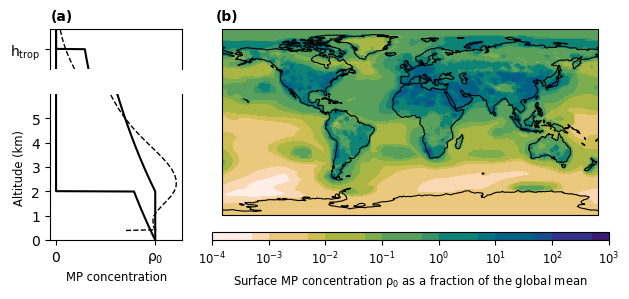

In [10]:
fig = plt.figure(figsize=(textwidth, textwidth/2.3), layout='constrained')
gs = fig.add_gridspec(3,2, height_ratios=(1,3,.2), width_ratios=(1,3),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

#================================================================================

# plot the well-mixed boundary layer vertical distribution with h_trop set to the global-mean
example_tropopause_height = spatial_mean(tropopause_height).values

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1:,0])

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.set_tick_params(top=False, bottom=False)
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

ax1.set_ylim(0,6)
ax2.set_ylim(0,6)
ax1.set_ylim(example_tropopause_height-1, example_tropopause_height+1)

ax1.set_xticks([])
ax2.set_xticks([0,1], [r'$0$',r'$\rho_0$'])
ax2.set_yticks([0,1,2,3,4,5])
ax1.set_yticks([example_tropopause_height], [r'$h_\mathrm{trop}$'])

z = np.linspace(0, example_tropopause_height+1, 1000)
for ax in [ax1, ax2]:
    ax.plot(np.where(z<=2, 0.3**(z/10), 0), z, c='k', ls='-', lw=1.5*lwmult,
           label='Density scaling')
    ax.plot(np.where(z<=2, 1, np.where(z<=example_tropopause_height, 0.3**((z-2)/10), 0)), z, c='k',
            ls='-', lw=1.5*lwmult, label='Well-mixed\nboundary layer')

ax2.set_ylabel('Altitude (km)', fontsize='small')
ax2.set_xlabel('MP concentration', fontsize='small')

ax2.plot(spatial_mean(mp_fragment_concentration), mp_fragment_concentration.altitude, 'k--', lw=1)

# For the upper panel, sample the MP concentration at a range of displacements
# from the local tropopause height

tropopause_displacement = np.linspace(-1, +1, 9)
ax1.plot([spatial_mean(mp_fragment_concentration.interp(altitude=tropopause_height+h)) for h in tropopause_displacement],
         example_tropopause_height + tropopause_displacement, 'k--', lw=1)

fig.text(.072, 1.005, '(a)', fontsize='medium', fontweight='bold', verticalalignment='bottom')

#================================================================================

ax = fig.add_subplot(gs[:2,1], projection=ccrs.PlateCarree())

sc_map = sc.ScicoSequential(cmap="rainforest_r")
sc_map.unif_sym_cmap(lift=None, bitonic=False, diffuse=True)
cmap = truncate_colormap(sc_map.get_mpl_color_map(), maxval=.8)

levels = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50, 100, 500, 1000]
cm = plot_contourf_map(ax, nonuniform_mp_number, transform=ccrs.PlateCarree(),
                       levels=levels, cmap=cmap, norm=mpl.colors.LogNorm())

cbar_ax = fig.add_subplot(gs[2,1])
cbar = plt.colorbar(cm, cax=cbar_ax, aspect=30, orientation='horizontal')
cbar.set_label(r'Surface MP concentration $\rho_0$ as a fraction of the global mean', fontsize='small')
cbar.ax.tick_params(labelsize='small')

fig.text(.34, 1.005, '(b)', fontsize='medium', fontweight='bold', verticalalignment='bottom',)

#================================================================================

plt.savefig('figures/fig4.pdf', bbox_inches='tight', transparent=True)

# Supplementary figure 2: Linear relationship of radiative forcing to surface concentration

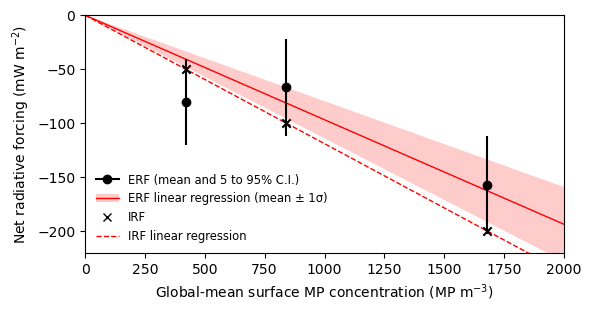

In [11]:
fig, ax = plt.subplots(1,1, figsize=(textwidth, textwidth/2))

concentration = [420, 840, 1680]
erf, erf_err, irf = [], [], []

for c in concentration:
    expt = f'clear_gamma(1-100)_exponential(0.3,2km)_uniform({c}m-3)'

    low, mean, high = EasyAerosolExperiment(expt).net_forcing_95ci() / 1e-3
    erf.append(mean)
    erf_err.append((high - low) / 2)

    irf.append(SocratesExperiment(expt).global_mean_net_forcing() / 1e-3)

    plt.errorbar([c], [erf[-1]], yerr=[erf_err[-1]], marker='o', c='k')
    plt.scatter([c], [irf[-1]], marker='x', c='k')

xs = np.linspace(0, 2000, 100)

popt, pcov = scipy.optimize.curve_fit(lambda x, a: a*x, concentration, erf, sigma=erf_err)
perr = np.sqrt(np.diag(pcov))
plt.plot(xs, popt*xs, 'r-', lw=1, zorder=-1)
plt.fill_between(xs, (popt+perr)*xs, (popt-perr)*xs, fc='r', alpha=.2)

popt, pcov = scipy.optimize.curve_fit(lambda x, a: a*x, concentration, irf)
perr = np.sqrt(np.diag(pcov))
plt.plot(xs, popt*xs, 'r--', lw=1, zorder=-1)

plt.xlim(0, 2000)
plt.ylim(-220, 0)

plt.legend([mpl.lines.Line2D([0], [0], color='k', marker='o'),
            (mpl.lines.Line2D([0], [0], color='r', lw=1), mpl.patches.Patch(facecolor='r', alpha=.2)),
             mpl.lines.Line2D([0], [0], marker='x', color='k', linestyle='none'),
             mpl.lines.Line2D([0], [0], color='r', linestyle='--', lw=1)],
           ['ERF (mean and 5 to 95% C.I.)', 'ERF linear regression (mean ± 1σ)', 'IRF', 'IRF linear regression'],
           frameon=False, fontsize='small')

plt.xlabel(r'Global-mean surface MP concentration (MP m$^{-3}$)')
plt.ylabel(r'Net radiative forcing (mW m$^{-2}$)')

fig.savefig('figures/supplementary-fig2.pdf', bbox_inches='tight');

# Supplementary figure 3: Variations on the size distribution

In [12]:
exponents = [0, 0.5, 1, 1.5, 2, 2.5, 3]
lower_bounds = [1, .5, .25, .1, .05, .025, .01]

values = np.full((len(lower_bounds), len(exponents), 4), np.nan)

for i, exponent in enumerate(exponents):
    for j, lower_bound in enumerate(lower_bounds):
        # Since each experiment has a different MP concentration (chosen to produce a minimally-noisy signal),
        # rather than write them all out we just glob for them.
        
        fname = (f'clear_powerlaw({exponent:.2f},{lower_bound if lower_bound!=1 else int(lower_bound)}-100)'
                 '_exponential(0.3,2km)_uniform(*m-3).nc')

        expts = [SocratesExperiment(f.stem) for f in Path('data/socrates/output').glob(fname)]
        assert len(expts) <= 1

        if expts:
            scale_factor = 1e3 / (expts[0].total_plastic_burden/1e9) # W/m2 to mW/m2/Tg
            values[j, i, 0] = expts[0].size_distribution.nth_moment(1)
            values[j, i, 1] = expts[0].global_mean_longwave_forcing() * scale_factor
            values[j, i, 2] = expts[0].global_mean_shortwave_forcing() * scale_factor
            values[j, i, 3] = expts[0].global_mean_net_forcing() * scale_factor

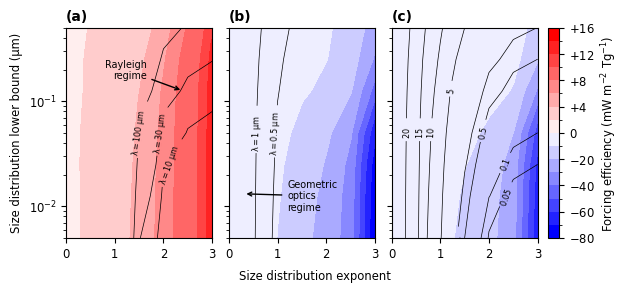

In [13]:
fig, axs = plt.subplots(1,3, figsize=(textwidth, textwidth/2.2), sharex=True, sharey=True, layout='constrained')
axs[0].set_yscale('log')

cmap = 'bwr'
norm = mpl.colors.BoundaryNorm(
    boundaries=[-80, -70, -60, -50, -40, -30, -20, -10, 0, 2, 4, 6, 8, 10, 12, 14, 16],
    ncolors=256)

# lower bounds are diameter bounds, so we divide by 2 to get radius
x, y = np.meshgrid(exponents, np.array(lower_bounds) / 2)
for i, ax in enumerate(axs):
    c = ax.contourf(x, y, values[:, :, i+1], cmap=cmap, norm=norm)
    c.set_edgecolor('face')

cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, pad=.015,
                  format=lambda x, pos: rf'${x:+.0f}$' if x !=0 else f'${x:.0f}$')
cb.ax.tick_params(labelsize='small')
cb.set_label('Forcing efficiency (mW m$^{-2}$ Tg$^{-1}$)', fontsize='small')

for lam in [10,30,100]: # wavelengths between 10 and 100 um for the longwave spectrum
    c = axs[0].contour(x, y, 2*np.pi*values[:,:,0]/lam, levels=[0.1], colors=['k'], linewidths=.5)
    plt.clabel(c, fmt=lambda _: rf'$\lambda={lam:.0f}$ μm', fontsize='xx-small')

axs[0].annotate('Rayleigh\nregime', (.8, .7), xytext=(.55, .8), xycoords='axes fraction',
                fontsize='x-small', c='k', ha='right', va='center', arrowprops=dict(arrowstyle='->', lw=1, color='k'))
    
for lam in [.5, 1]: # wavelengths between 300 and 2500 nm for the solar spectrum
    c = axs[1].contour(x, y, 2*np.pi*values[:,:,0]/lam, levels=[100], colors=['k'], linewidths=.5)
    plt.clabel(c, fmt=lambda _: rf'$\lambda={lam:.{int(abs(np.minimum(0, np.floor(np.log10(lam)))))}f}$ μm', fontsize='xx-small')

axs[1].annotate('Geometric\noptics\nregime', (.1, .21), xytext=(.4, .2), xycoords='axes fraction',
                fontsize='x-small', c='k', ha='left', va='center', arrowprops=dict(arrowstyle='->', lw=1, color='k'))

cont = axs[2].contour(x, y, np.log10(values[:, :, 0]), levels=np.log10([.01, .05, .1, .5, 1, 5, 10, 15, 20]),
                      linewidths=.5, colors='k', linestyles='-')
plt.clabel(cont, fmt=lambda x: rf'${10**x:.{int(abs(np.minimum(0, np.floor(x))))}f}$', fontsize='xx-small')

axs[0].set_ylabel('Size distribution lower bound (μm)', fontsize='small')
fig.supxlabel('Size distribution exponent', fontsize='small')

for i, ax in enumerate(axs):
    ax.tick_params(labelsize='small')
    ax.annotate(f'({chr(97+i)})', xy=(-0.05, 1.12), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                fontsize='medium', fontweight='bold', ha='left', va='top')

fig.savefig('figures/supplementary-fig3.pdf', bbox_inches='tight');

# Supplementary figure 4: Dependence of radiative forcing on surface albedo

In [14]:
albedo = xr.open_dataset('data/shortwave_albedo.nc').albedo
min_albedo, max_albedo = albedo.values.min(), albedo.values.max()

nonuniform_mp_number = xr.open_dataset('data/nonuniform_mp_concentration.nc').mp_concentration

In [15]:
def plot_curve(ax, expt_str, **line_kwargs):
    expt = SocratesExperiment(expt_str)

    number_concentration = (
        (nonuniform_mp_number if 'evangeliou' in expt_str else xr.ones_like(nonuniform_mp_number))
        * expt.surface_concentration)

    nbins = 40
    bin_edges = np.linspace(min_albedo * .99, max_albedo * 1.01, nbins+1)
    weights = np.cos(np.deg2rad(np.meshgrid(albedo.lon, albedo.lat)[1])).transpose()
    mask = number_concentration > 1

    def make_curve(values):
        curve = []
        values = values.transpose(*albedo.dims)
        
        for i in range(nbins):
            _mask = (albedo > bin_edges[i]) & (albedo <= bin_edges[i+1]) & mask
            mean = np.average(values.values[_mask], weights=weights[_mask])
            yerr = np.sqrt( np.average(((values.values - mean)**2)[_mask], weights=weights[_mask]) )
            curve.append(((bin_edges[i]+bin_edges[i+1])/2, mean, yerr))
    
        return (np.array([p[j] for p in curve]) for j in range(3))

    x, mean, std = make_curve(expt.longwave_efficiency() * 1e-3)
    ax.plot(x, mean, **(dict(c='r', ls='-') | line_kwargs))
    ax.fill_between(x, mean-std, mean+std, facecolor='r', alpha=.2)
    
    x, mean, std = make_curve(expt.shortwave_efficiency() * 1e-3)
    ax.plot(x, mean, **(dict(c='b', ls='-') | line_kwargs))
    ax.fill_between(x, mean-std, mean+std, facecolor='b', alpha=.2)
    
    x, mean, std = make_curve(expt.net_efficiency() * 1e-3)
    ax.plot(x, mean, **(dict(c='k', ls='-') | line_kwargs))
    ax.fill_between(x, mean-std, mean+std, facecolor='k', alpha=.2)

    ax.axhline(0, lw=.8, c='k')
    ax.set_xlim(0,1)

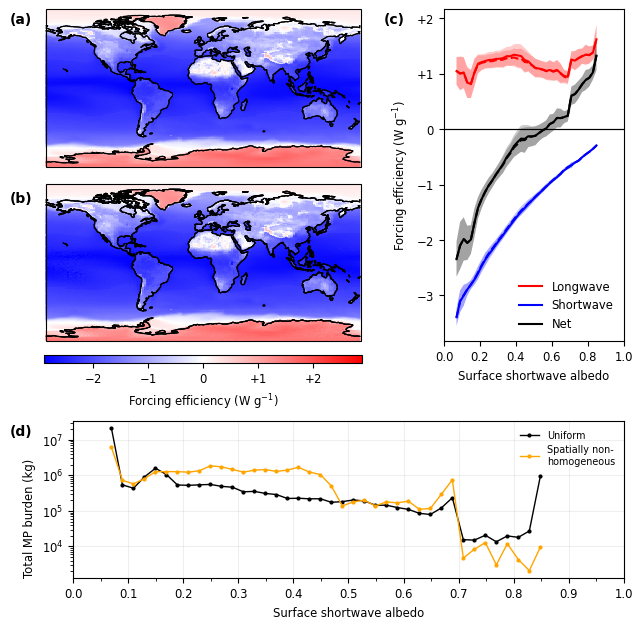

In [16]:
fig = plt.figure(figsize=(textwidth, textwidth), layout='constrained')
parent_gs = mpl.gridspec.GridSpec(2,1, figure=fig, height_ratios=[3,1.5])

gs1 = parent_gs[0].subgridspec(2,2, width_ratios=[2,1])

#================================================================================

ax00 = fig.add_subplot(gs1[0,0], projection=ccrs.PlateCarree())
ax00.coastlines(lw=.8)

ax10 = fig.add_subplot(gs1[1,0], projection=ccrs.PlateCarree())
ax10.coastlines(lw=.8)

norm = mpl.colors.CenteredNorm()
cmap = 'bwr'

expt = SocratesExperiment('clear_gamma(1-100)_exponential(0.3,2km)_uniform(1680m-3)')
plot_pcolormesh_map(ax00, expt.net_efficiency() / 1e3, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())

expt = SocratesExperiment('clear_gamma(1-100)_exponential(0.3,2km)_evangeliou(3070m-3)')
plot_pcolormesh_map(ax10, expt.net_efficiency() / 1e3, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())

plot_contourf_map(ax10, nonuniform_mp_number * expt.surface_concentration, transform=ccrs.PlateCarree(),
                  hatches=['/////',''], levels=[0,100], colors='none')

cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=[ax00, ax10],
                  orientation='horizontal', pad=-.08, fraction=.024, aspect=40,
                  format=lambda x, pos: rf'${x:+.0f}$' if x != 0 else rf'${x:.0f}$')
cb.ax.tick_params(labelsize='small')
cb.set_label(r'Forcing efficiency (W g$^{-1}$)', fontsize='small')

fig.text(-.015, .989, '(a)', fontsize='medium', fontweight='bold', verticalalignment='top')
fig.text(-.015, .698, '(b)', fontsize='medium', fontweight='bold', verticalalignment='top')

#================================================================================

ax01 = fig.add_subplot(gs1[:,1])

plot_curve(ax01, 'clear_gamma(1-100)_exponential(0.3,2km)_uniform(1680m-3)')
plot_curve(ax01, 'clear_gamma(1-100)_exponential(0.3,2km)_evangeliou(3070m-3)', ls='--')

ax01.legend(handles=[mpl.lines.Line2D([0], [0], color='r', label='Longwave'),
                     mpl.lines.Line2D([0], [0], color='b', label='Shortwave'),
                     mpl.lines.Line2D([0], [0], color='k', label='Net'),],
           frameon=False, fontsize='small')

ax01.set_xlabel('Surface shortwave albedo', fontsize='small')
ax01.set_ylabel(r'Forcing efficiency (W g$^{-1}$)', fontsize='small')
ax01.tick_params(labelsize='small')
ax01.yaxis.set_major_formatter(lambda x, pos: rf'${x:+.0f}$' if x != 0 else rf'${x:.0f}$')

fig.text(.59, .989, '(c)', fontsize='medium', fontweight='bold', verticalalignment='top')

#================================================================================

gs2 = parent_gs[1].subgridspec(1,1)
ax = fig.add_subplot(gs2[0,0])


nbins = 40
bin_edges = np.linspace(min_albedo * .99, max_albedo * 1.01, nbins+1)
weights = np.cos(np.deg2rad(np.meshgrid(albedo.lon, albedo.lat)[1])).transpose()

def make_curve(experiment):
    expt = SocratesExperiment(experiment)
    mdist = (expt.mass_distribution / expt.surface_concentration).transpose(*albedo.dims)

    curve = []
    for i in range(nbins):
        mask = (albedo > bin_edges[i]) * (albedo <= bin_edges[i+1])
        total_mass = spatial_integral((mdist * mask).transpose())
        curve.append(((bin_edges[i]+bin_edges[i+1])/2, total_mass))

    return (np.array([p[j] for p in curve ]) for j in range(2))


x, mean_uniform = make_curve('clear_gamma(1-100)_exponential(0.3,2km)_uniform(1680m-3)')
ax.plot(x, mean_uniform, 'k-', marker='o', markersize=2, linewidth=1, label='Uniform')

x, mean_nonuniform = make_curve('clear_gamma(1-100)_exponential(0.3,2km)_evangeliou(3070m-3)')
ax.plot(x, mean_nonuniform , c='orange', marker='o', markersize=2, linewidth=1, label='Spatially non-\nhomogeneous')

ax.grid(alpha=.2, linewidth=.8)
ax.tick_params(labelsize='small')
ax.set_xlim(0,1)
ax.set_yscale('log')
ax.legend(frameon=False, fontsize='x-small')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=.1))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(base=.05))

ax.set_xlabel('Surface shortwave albedo', fontsize='small')
ax.set_ylabel('Total MP burden (kg)', fontsize='small', loc='bottom')

fig.text(-.015, .322, '(d)', fontsize='medium', fontweight='bold', verticalalignment='top')

#================================================================================

plt.savefig('figures/supplementary-fig4.pdf', bbox_inches='tight', transparent=True);